In [1]:
import librosa as lb

In [2]:
import numpy as np

In [3]:
from matplotlib import pyplot as plt

In [4]:
path = r"C:\\Users\\rrame12\\Desktop\\Results_dwt100\\12\\"

In [7]:
v, fs = lb.load(path+'tvocal.wav')
b, fs = lb.load(path+'tbass.wav')
d, fs = lb.load(path+'tdrums.wav')

bv, fs = lb.load(path+'bvocal.wav')
bb, fs = lb.load(path+'bbass.wav')
bd, fs = lb.load(path+'bdrums.wav')

pv, fs = lb.load(path+'pvocal.wav')
pb, fs = lb.load(path+'pbass.wav')
pd, fs = lb.load(path+'pdrums.wav')

In [8]:
V = lb.stft(v) 
B = lb.stft(b) 
D = lb.stft(d) 

BV = lb.stft(bv) 
BB = lb.stft(bb) 
BD = lb.stft(bd) 

PV = lb.stft(pv) 
PB = lb.stft(pb) 
PD = lb.stft(pd) 

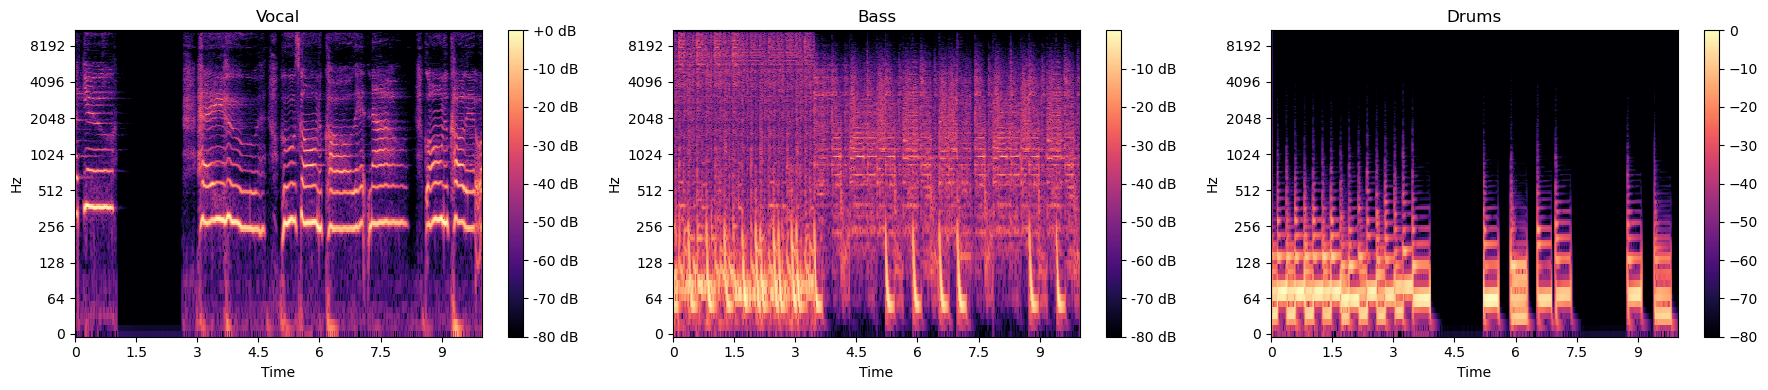

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

v_db = lb.amplitude_to_db(np.abs(V), ref=np.max)
img = lb.display.specshow(v_db, sr=fs, x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Vocal')
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')

b_db = lb.amplitude_to_db(np.abs(B), ref=np.max)
img2 = lb.display.specshow(b_db, sr=fs, x_axis='time', y_axis='log', ax=ax[1])
ax[1].set(title='Bass')
fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

d_db = lb.amplitude_to_db(np.abs(D), ref=np.max)
img3 = lb.display.specshow(d_db, y_axis='log', x_axis='time', ax=ax[2])
ax[2].set(title='Drums')
fig.colorbar(img3, ax=ax[2])

plt.tight_layout()
plt.show()

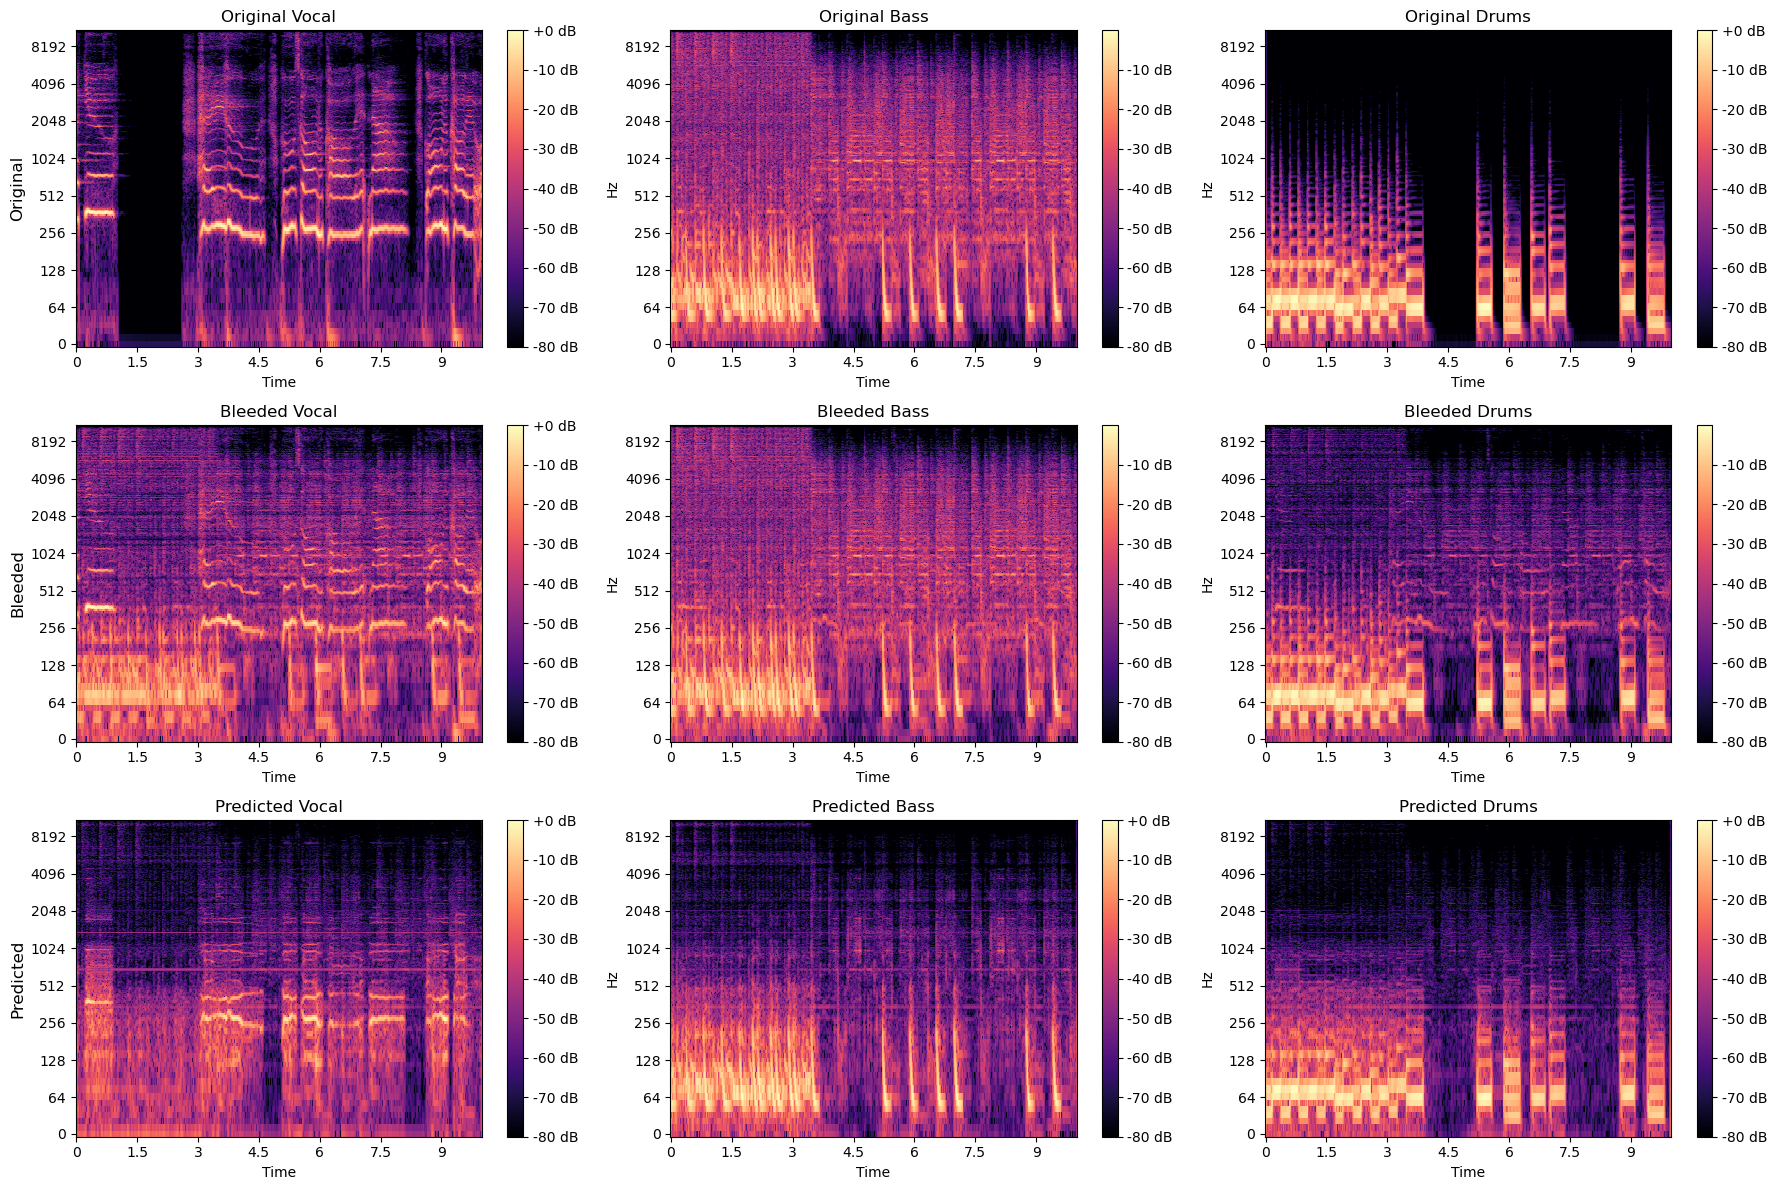

In [10]:
# Create 3x3 subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# Define components and data groups
components = ['Vocal', 'Bass', 'Drums']
data_groups = [
    (V, B, D),        # First row data
    (BV, BB, BD),     # Second row data
    (PV, PB, PD)      # Third row data
]
titles = ['Original', 'Bleeded', 'Predicted']

# Plot all spectrograms
for row_idx, (row_data, row_title) in enumerate(zip(data_groups, titles)):
    for col_idx, (component, data) in enumerate(zip(components, row_data)):
        # Convert to dB
        db_data = lb.amplitude_to_db(np.abs(data), ref=np.max)
        
        # Plot spectrogram
        img = lb.display.specshow(db_data, sr=fs, 
                                x_axis='time', y_axis='log', 
                                ax=ax[row_idx, col_idx])
        
        # Set titles and labels
        ax[row_idx, col_idx].set(title=f'{row_title} {component}')
        fig.colorbar(img, ax=ax[row_idx, col_idx], format='%+2.0f dB')

# Add row labels
for ax_row, label in zip(ax[:,0], titles):
    ax_row.set_ylabel(label, rotation=90, size='large')

plt.tight_layout()
plt.show()

In [27]:
 def sim(S1, S2, percentage=90):
    epsilon = 1e-6
    S1 = np.abs(S1) + epsilon
    S2 = np.abs(S2) + epsilon

    S1_norm = (S1 - S1.min()) / (S1.max() - S1.min())
    S2_norm = (S2 - S2.min()) / (S2.max() - S2.min())
    
    # Compute similarity (emphasize co-occurrence of strong amplitudes)
    similarity = S1_norm * S2_norm  # Range: [0, 1]
    # Adaptive threshold (e.g., 90th percentile of similarity values)
    threshold = np.percentile(similarity, percentage)  # Adjust percentile as needed
     
    binary_mask = (similarity >= threshold).astype(float)
    return binary_mask

In [51]:
cleaned_mask = sim(np.abs(BV), np.abs(PV), percentage=95)

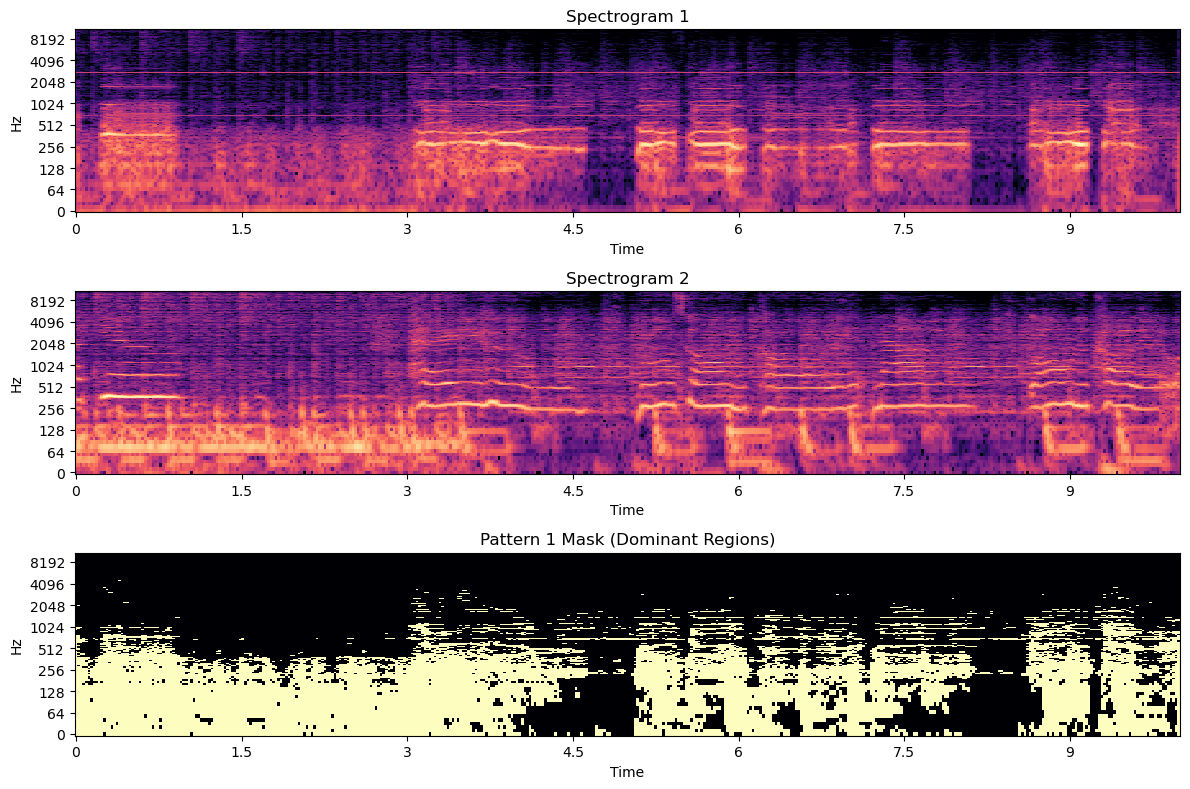

In [54]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [56]:
from scipy.signal import correlate2d

def cross_correlation_mask(S1, S2, kernel_size=(3,3)):
    # Normalize spectrograms
    S1_norm = (S1 - S1.mean()) / S1.std()
    S2_norm = (S2 - S2.mean()) / S2.std()
    
    # Compute local cross-correlation
    kernel = np.ones(kernel_size)
    corr = correlate2d(S1_norm, S2_norm, mode='same', boundary='symm')
    norm = np.sqrt(correlate2d(S1_norm**2, np.ones_like(S2_norm), mode='same')) * \
           np.sqrt(correlate2d(np.ones_like(S1_norm), S2_norm**2, mode='same'))
    mask = corr / (norm + 1e-6)
    return np.clip(mask, 0, 1)

In [ ]:
cleaned_mask = cross_correlation_mask(np.abs(BV), np.abs(PV),(3,3))

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [17]:
def spectral_flux_mask(S1, S2):
    flux1 = np.diff(S1, axis=1)
    flux2 = np.diff(S2, axis=1)
    flux_diff = np.abs(flux1 - flux2)
    flux_sim = 1 / (1 + flux_diff)  # Invert difference to similarity
    # Pad to match original shape
    return np.pad(flux_sim, ((0,0), (0,1)), mode='edge')


cleaned_mask = spectral_flux_mask(np.abs(BV), np.abs(PV))

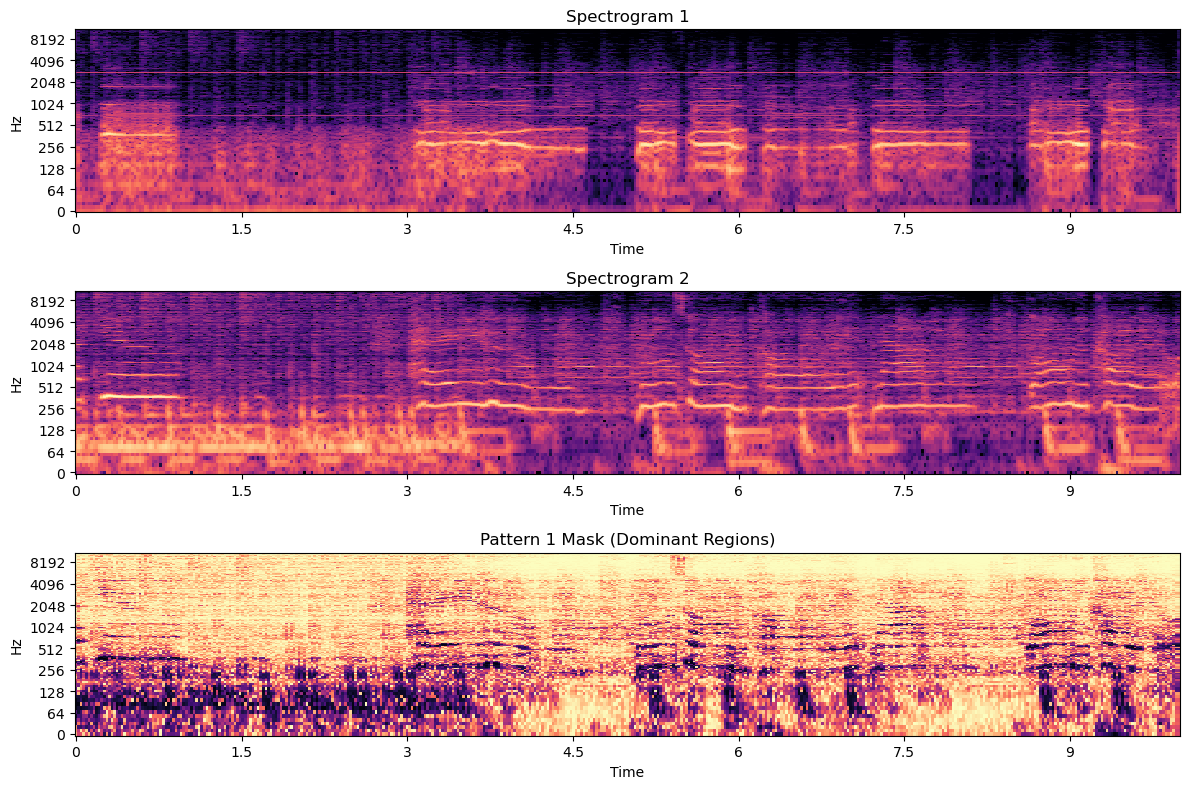

In [18]:
import librosa
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [31]:
restored =(1-cleaned_mask) * np.abs(BV)

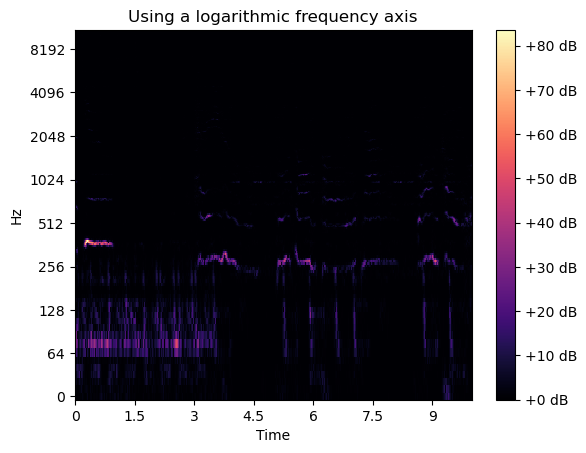

In [32]:
fig, ax = plt.subplots()
img = librosa.display.specshow(restored, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Using a logarithmic frequency axis')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [35]:
import ot

def wasserstein_mask(S1, S2):
    mask = np.zeros_like(S1)
    for t in range(S1.shape[1]):
        # Treat each time frame as a distribution
        a = S1[:, t] + 1e-6
        b = S2[:, t] + 1e-6
        M = ot.dist(a.reshape(-1,1), b.reshape(-1,1))
        mask[:, t] = 1 - ot.emd2(a, b, M)  # Normalize based on max possible cost
    return mask

cleaned_mask = wasserstein_mask(np.abs(BV), np.abs(PV))

AssertionError: 
Arrays are not almost equal to 6 decimals
a and b vector must have the same sum
Mismatched elements: 1 / 1 (100%)
Max absolute difference: 441.13186604
Max relative difference: 6.3791121
 x: array(510.284416)
 y: array([69.15255])

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [40]:
def kl_divergence_mask(S1, S2, epsilon=1e-6):
    P = S1 + epsilon
    Q = S2 + epsilon
    kl = np.sum(P * np.log(P / Q), axis=0)
    # Convert divergence to similarity
    kl_sim = 1 / (1 + kl)
    return kl_sim

cleaned_mask = kl_divergence_mask(np.abs(BV), np.abs(PV))

In [42]:
cleaned_mask.shape, BV.shape

((431,), (1025, 431))

IndexError: tuple index out of range

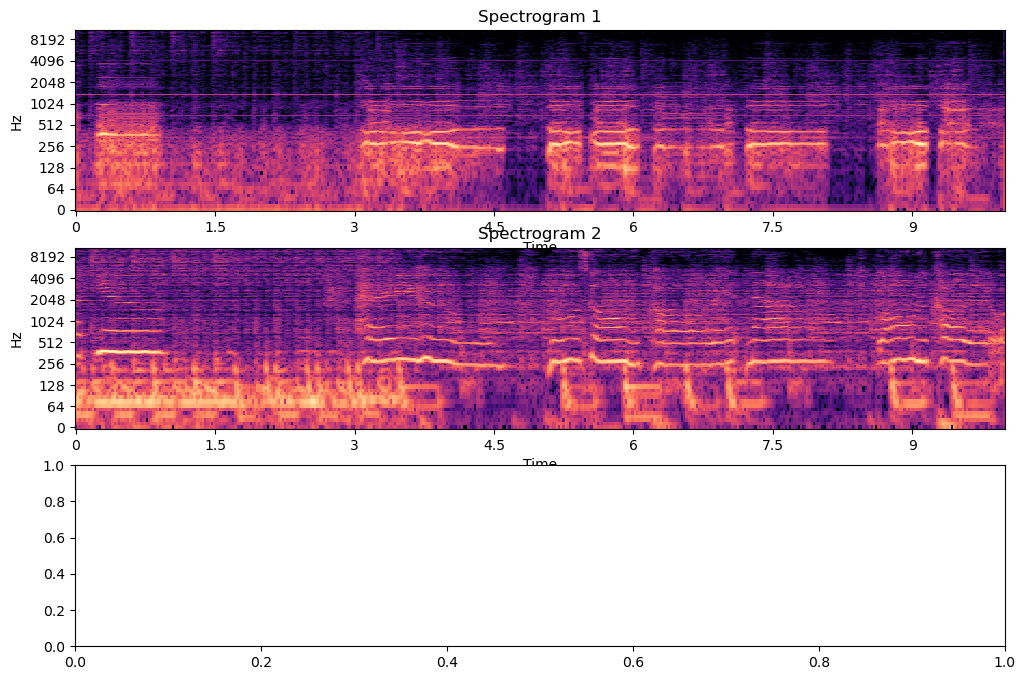

In [37]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [63]:
def create_soft_mask(mag_stft, percentile=99):
    threshold = np.percentile(mag_stft, percentile)
    return np.clip(mag_stft / threshold, 0, 1)

cleaned_mask1 = create_soft_mask(np.abs(BV))

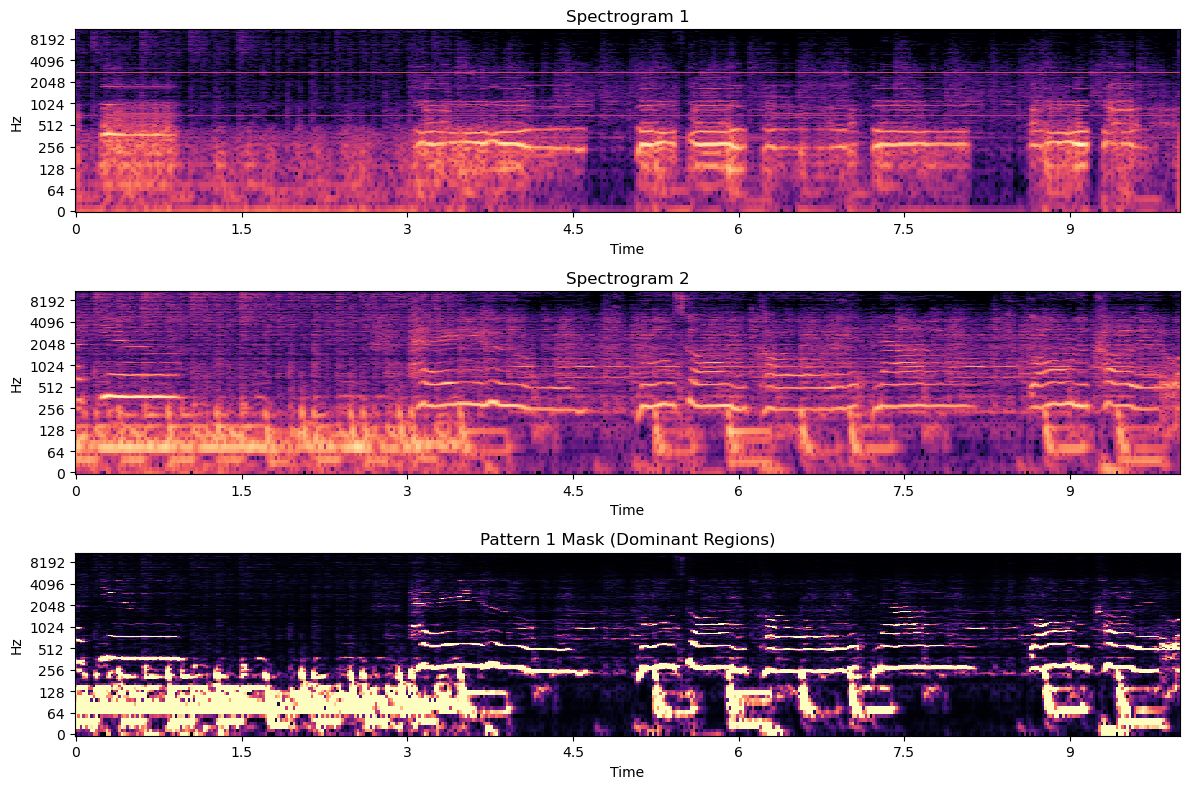

In [64]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask1, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [66]:
def create_soft_mask(mag_stft, percentile=99.9):
    threshold = np.percentile(mag_stft, percentile)
    return np.clip(mag_stft / threshold, 0, 1)

cleaned_mask2 = create_soft_mask(np.abs(PV))

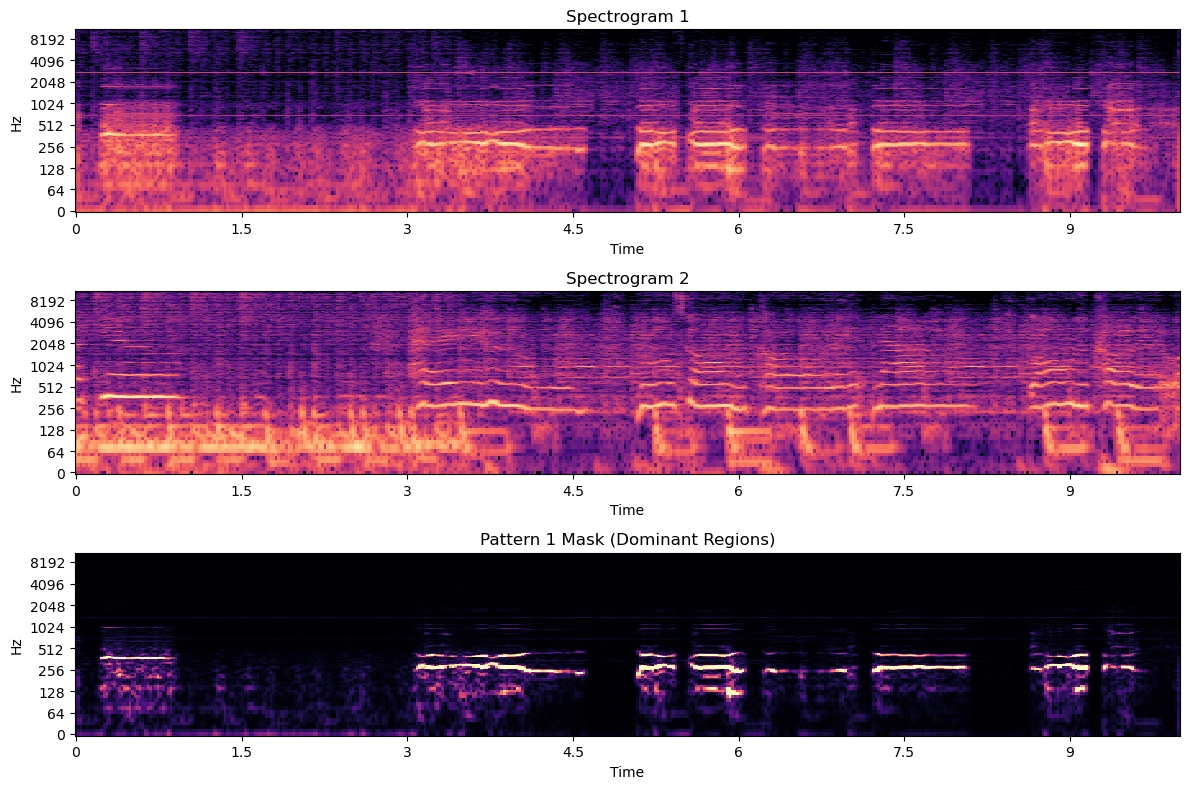

In [67]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(cleaned_mask2, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()

In [75]:
import numpy as np

def get_common_soft_mask(mask1, mask2, operation='min'):
    """
    Returns a soft mask representing common regions between two input soft masks.
    
    Args:
        mask1 (np.ndarray): First soft mask (values 0-1)
        mask2 (np.ndarray): Second soft mask (values 0-1)
        operation (str): Method for combining masks:
            'min' - take minimum value (default)
            'product' - multiply values
            'average' - take average
    
    Returns:
        np.ndarray: Combined soft mask
    """
    # Validate inputs
    assert mask1.shape == mask2.shape, "Masks must have same shape"
    assert np.all((mask1 >= 0) & (mask1 <= 1)), "Mask1 values must be in [0,1]"
    assert np.all((mask2 >= 0) & (mask2 <= 1)), "Mask2 values must be in [0,1]"
    
    # Combine masks
    if operation == 'min':
        return np.minimum(mask1, mask2)
    elif operation == 'product':
        return mask1 * mask2
    elif operation == 'average':
        return (mask1 + mask2) / 2
    else:
        raise ValueError("Supported operations: 'min', 'product', 'average'")


common_mask = get_common_soft_mask(cleaned_mask1, cleaned_mask2, operation='min')

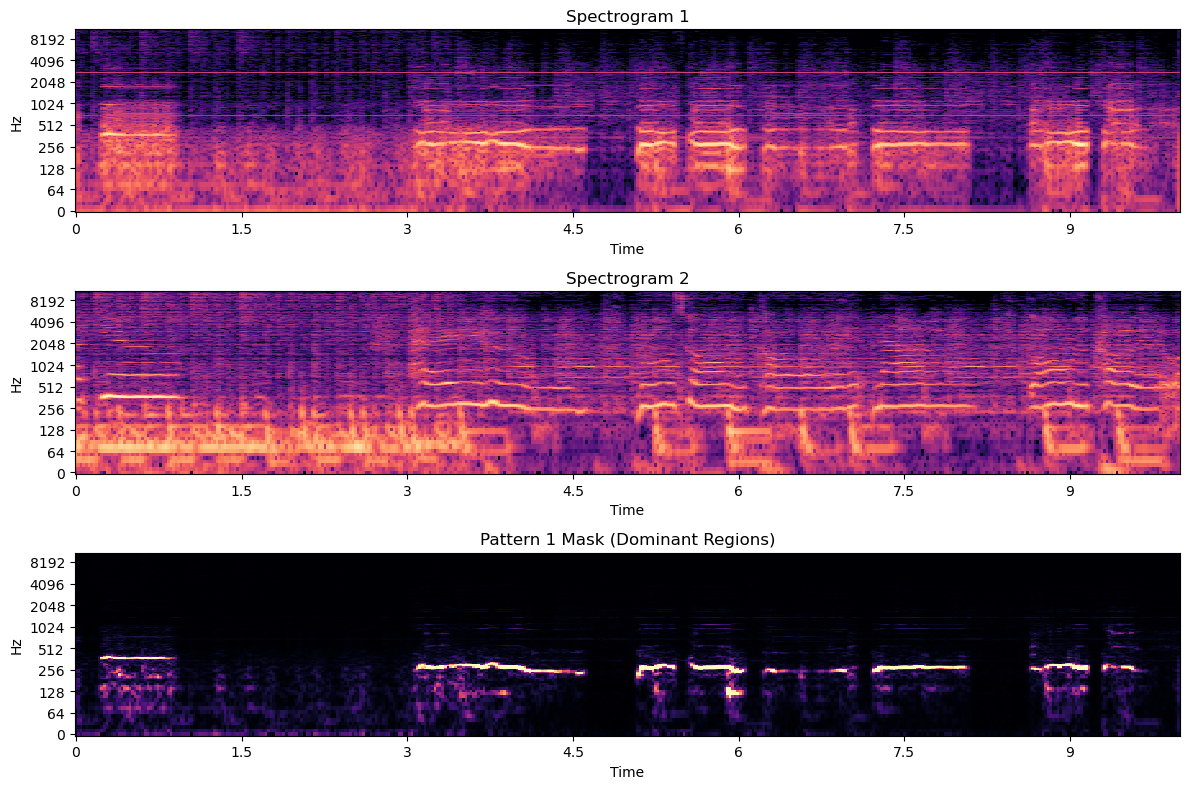

In [76]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 8))

# Plot Spectrogram 1
librosa.display.specshow(librosa.amplitude_to_db(np.abs(PV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[0])
ax[0].set(title='Spectrogram 1')

# Plot Spectrogram 2
librosa.display.specshow(librosa.amplitude_to_db(np.abs(BV), ref=np.max),
                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Spectrogram 2')

# Plot Mask
librosa.display.specshow(common_mask, y_axis='log', x_axis='time',
                         cmap='magma', ax=ax[2])
ax[2].set(title='Pattern 1 Mask (Dominant Regions)')

plt.tight_layout()
plt.show()